In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.Qiskit_CP_VQA import CP_VQA

from joblib import Parallel, delayed

from src.Chain import Chain
from src.Qubo import Qubo
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       check_qubo)

In [2]:
def simulate(settings: dict):
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=settings['N'], seed=settings['seed'])
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=settings['N'],
                                                                k=settings['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=settings['alpha'])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=settings['alpha'],
                         lmbda=lmbda+1, # Adding small constant purposely
                         k=settings['k'])
    qubo = Qubo(Q=Q, offset=offset) 
    qubo.subspace_c_min, qubo.subspace_c_max = constrained_result['c_min'], constrained_result['c_max']
    qubo.subspace_x_min, qubo.subspace_x_max = constrained_result['s_min'], constrained_result['s_max']
    qubo.full_space_c_min, qubo.full_space_c_max = full_result['c_min'], full_result['c_max']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=settings['alpha'], k=settings['k'])
     
    
    full_h = CP_VQA(N_qubits=settings['N'],
                    cardinality=settings['k'],
                    layers=settings['L'],
                    topology=settings['topology'],
                    with_next_nearest_neighbors=settings['w_nnn'],
                    approximate_hamiltonian=False,
                    qubo=qubo)
     
    trotterized_h = CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           with_next_nearest_neighbors=settings['w_nnn'],
                           approximate_hamiltonian=True,
                           qubo=qubo)
     
    
     # Generating initial guess for rotation angles
    np.random.seed(settings['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = settings['L'] * len(settings['topology'].get_NNN_indices()) if settings['w_nnn'] else settings['L'] * len(settings['topology'].get_NN_indices())
    CPVQA_theta_i = np.random.uniform(theta_min, theta_max, N_angles)
    QAOA_theta_i = np.random.uniform(theta_min, theta_max, 2*settings['L'])
    
    
    full_h_sim_res = sc.optimize.minimize(fun=full_h.get_cost, 
                                        x0=QAOA_theta_i,
                                        method=settings['opt_method'],
                                        options={'disp': False, 
                                                 'maxiter': settings['max_iter']},
                                        callback=full_h.callback)
    full_h_norm_c = np.min(full_h.normalized_costs)
    full_h_p = np.max(full_h.opt_state_probabilities)    
    
    
    trotterized_h_sim_res = sc.optimize.minimize(fun=trotterized_h.get_cost, 
                                          x0=CPVQA_theta_i,
                                          method=settings['opt_method'],
                                          options={'disp': False, 
                                                   'maxiter': settings['max_iter']},
                                          callback=trotterized_h.callback)
    trotterized_h_norm_c = np.min(trotterized_h.normalized_costs)
    trotterized_h_p = np.max(trotterized_h.opt_state_probabilities)
    
    return  {'N':settings['N'], 'full_h': {'c':full_h_norm_c,'p':full_h_p}, 'trotterized_h': {'c':trotterized_h_norm_c,'p':trotterized_h_p}}

In [3]:
layer_dict = {2:1,  3:1,  4:1,
              5:2,  6:2,  7:3,
              8:5,  9:6,  10:6,
              11:5, 12:5, 13:5,
              14:5, 15:5, 16:5,
              17:6, 18:6, 19:6, 
              20:7, 21:7, 22:7}

max_iter = 500
alpha=0.5
N_seeds = 100
N_min, N_max = 2,7
sim_settings = []
for seed in range(N_seeds):
    for N in range(N_min, N_max+1):
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i%2 == 0 else 1 for i in range(N)]))
        setting = {'N'         :N,       'alpha'   :alpha,   'L'       :layer_dict[N], 
                   'seed'      :seed,    'topology':topology,'max_iter':max_iter,
                   'opt_method':'COBYLA','w_nnn'   :True,    'k'       :N//2}
        sim_settings.append(setting)

In [ ]:
N_jobs=15
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(setting) for setting in sim_settings)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed:    4.9s
[Parallel(n_jobs=15)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=15)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=15)]: Done   6 tasks      | elapsed:    6.9s
[Parallel(n_jobs=15)]: Done   7 tasks      | elapsed:    7.0s
[Parallel(n_jobs=15)]: Done   8 tasks      | elapsed:    7.1s
[Parallel(n_jobs=15)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:   10.8s
[Parallel(n_jobs=15)]: Done  12 tasks      | elapsed:   11.7s
[Parallel(n_jobs=15)]: Done  13 tasks      | elapsed:   12.9s
[Parallel(n_jobs=15)]: Done  14 tasks      | elapsed:   16.5s
[Parallel(n_jobs=15)]: Done  15 tasks      | elapsed:  

In [19]:
full_h = {N: [] for N in range(N_min,N_max+1)}
trotterized_h = {N: [] for N in range(N_min,N_max+1)}
for res in r:
    full_h[res['N']].append([res['full_h']['c'],res['full_h']['p']])
    trotterized_h[res['N']].append([res['trotterized_h']['c'],res['trotterized_h']['p']])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

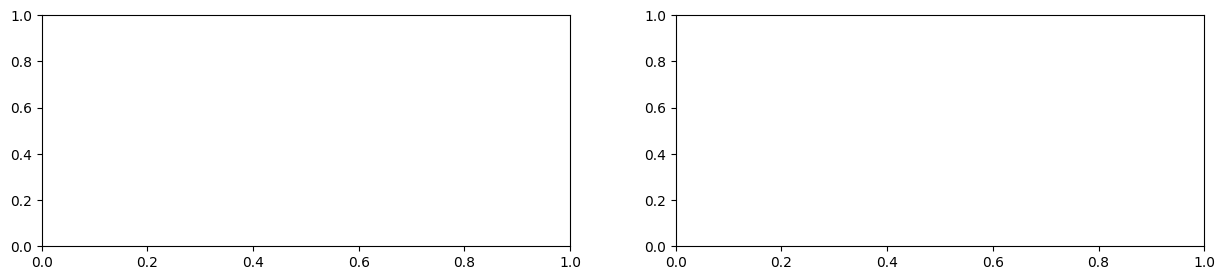

In [13]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
N_vals = [N for N in range(N_min, 8)]
ax[0].errorbar(N_vals, 
            [np.mean(np.array(full_h[N])[:,0]) for N in N_vals], 
            [np.std(np.array(full_h[N])[:,0]) for N in N_vals], label='Full H', capsize=2.5, fmt='.-', ms=10)
ax[0].errorbar(N_vals, 
            [np.mean(np.array(trotterized_h[N])[:,0]) for N in N_vals], 
            [np.std(np.array(trotterized_h[N])[:,0]) for N in N_vals], label='Trotterized H', capsize=2.5, fmt='.-', ms=10)
ax[1].errorbar(N_vals, 
            [np.mean(np.array(full_h[N])[:,1]) for N in N_vals], 
            [np.std(np.array(full_h[N])[:,1]) for N in N_vals], label='Full H', capsize=2.5, fmt='.-', ms=10)
ax[1].errorbar(N_vals, 
            [np.mean(np.array(trotterized_h[N])[:,1]) for N in N_vals], 
            [np.std(np.array(trotterized_h[N])[:,1]) for N in N_vals], label='Trotterized H', capsize=2.5, fmt='.-', ms=10)

ax[0].set_ylabel('Normalized cost')
ax[1].set_ylabel('Ground state prob.')

for i in range(2):
    ax[i].legend(loc='best')
    ax[i].set_xticks(N_vals)
    ax[i].set_xlabel('# Qubits (Portfolio size)')
plt.show()
